In [1]:
# Import statements and notebook settings
from keras.datasets import mnist
import matplotlib.pyplot as plt
import numpy as np
import copy
import time
from sklearn import linear_model
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

show_mnist_plots = True

In [19]:
# Plotting functions
def plot_heat_map(coef_arr, lambda_labels, fig_size_x=12, fig_size_y=12):
    """Plot heat maps (plural) for all coef in coef_arr

    Args:
        coef_arr (List[np.array]): List of 2D np arrays containing coef to plot
        lambda_labels (List[float]): List of lambda values to label plots. Must have length equal to coef_arr
    """
    plt.rcParams['figure.figsize'] = [fig_size_x, fig_size_y]
    if isinstance(coef_arr, (list)) is False:
        coef_arr = [coef_arr]
    if isinstance(lambda_labels, (list)) is False:
        lambda_labels = [lambda_labels]

    fig,axs = plt.subplots(len(lambda_labels),1)
    if len(lambda_labels) == 1:
        axs = [axs]
    for j, coef in enumerate(coef_arr):
        # x = coef.coef_
        x_pcolor = axs[j].pcolor(coef,cmap='hot')
        fig.colorbar(x_pcolor, ax=axs[j])
        axs[j].set_ylabel(f"lambda={lambda_labels[j]}") 
    return


def plot_confusion(model_coef, test_data, test_label, lambda_val, fig_size=12):
    plt.rcParams['figure.figsize'] = [fig_size, fig_size]
    pred = test_data@model_coef.T
    
    conf_pred = np.argmax(pred, axis=1)
    conf_mat = confusion_matrix(test_label, conf_pred, normalize='pred')
    disp = ConfusionMatrixDisplay(conf_mat)
    disp.plot()
    plt.title(f"Lambda = {lambda_val}")
    plt.show()
    return


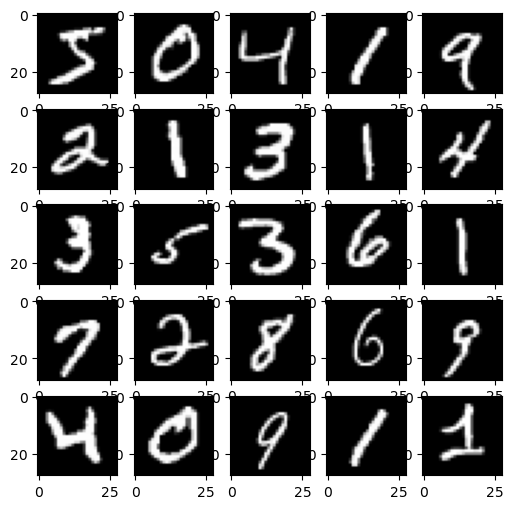

In [3]:
# Import MNIST data and vectorize it
fig_size = 6
plt.rcParams['figure.figsize'] = [fig_size,]

(train_data, train_label), (test_data, test_label) = mnist.load_data()

if show_mnist_plots:
    mnist_plots = (5)**2     # set to be squared number
    root_mnist = int(np.sqrt(mnist_plots))
    fig, axs = plt.subplots(root_mnist, root_mnist)
    for i in range(mnist_plots):
        axs[i//root_mnist, i%root_mnist].imshow(train_data[i], cmap=plt.get_cmap('gray'))
    plt.show()

num_labels = 10     # set equal to number of labels (digits)

def one_hot(labels, num_labels):
    # return array of one-hot encoding to match number of labels
    return np.eye(num_labels)[np.array(labels).reshape(-1)]

def vectorize_data(data, label, num_labels):
    # flatten each image in data into 1D array and create one-hot encoding result matrix
    data_vector = data.reshape(data.shape[0], -1)
    label_vector = one_hot(label, num_labels)
    return data_vector, label_vector

train_A, train_B = vectorize_data(train_data, train_label, num_labels)
test_A, test_B = vectorize_data(test_data, test_label, num_labels)

iter 0: 273.9947683811188 sec
iter 1: 186.6049783229828 sec
iter 2: 101.9067108631134 sec
iter 3: 53.51445531845093 sec


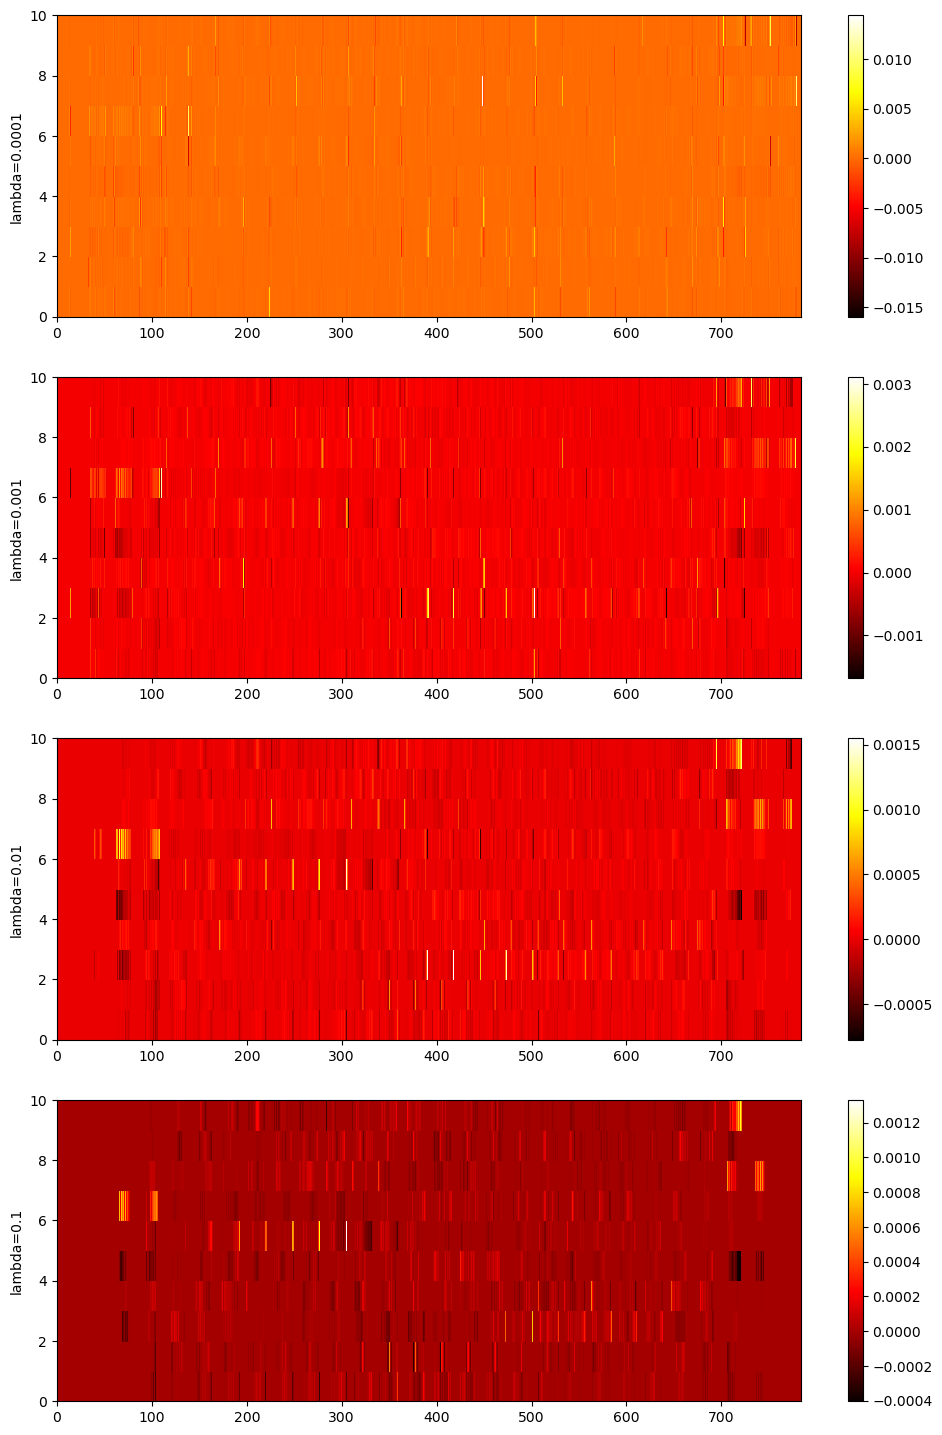

In [4]:
# solve AX=B to find pixels that map to correct label outcome and plot heat maps of coefficients

# lambda is regularization factor in Lasso algo
lambda_array = [1.5e-3, 1.7e-3, 1e-2, 2e-2, 5e-2, 7e-2]
lambda_array = [1e-4, 1e-3, 1e-2, 1e-1]

def generate_models(A, b, lambda_array):
    model_list = []
    for i, lam in enumerate(lambda_array):
        start = time.time()
        if lam==0:
            clf = linear_model.LinearRegression(fit_intercept=False)
        else:
            clf = linear_model.Lasso(alpha=lam, 
                                     fit_intercept=False, 
                                     warm_start=True, 
                                     selection='random',
                                    #  max_iter=200
                                     )
        clf.fit(A, b)
        elapsed = time.time() - start
        print(f"iter {i}: {elapsed} sec")
        model_list.append(clf)
    return model_list

clf_array = generate_models(train_A, train_B, lambda_array)

plot_heat_map([model.coef_ for model in clf_array], lambda_array, fig_size_y=18)
# fig,axs = plt.subplots(len(lambda_array),1)
# for j, lam in enumerate(lambda_array):
#     x = clf_array[j].coef_
#     x_pcolor = axs[j].pcolor(x,cmap='hot')
#     fig.colorbar(x_pcolor, ax=axs[j])
#     axs[j].set_ylabel(f"lam={lam}") 

plt.show()

In [5]:
# print number of iterations for each model
for count, model in enumerate(clf_array):
    print(f"lambda: {lambda_array[count]}\titerations: {model.n_iter_}")
    # print(f"\t\t\tfeatures: {model.n_features_in_}")

lambda: 0.0001	iterations: [724, 707, 712, 739, 760, 747, 690, 696, 717, 760]
lambda: 0.001	iterations: [580, 506, 510, 572, 560, 515, 561, 535, 566, 549]
lambda: 0.01	iterations: [320, 408, 345, 324, 350, 311, 337, 292, 337, 341]
lambda: 0.1	iterations: [267, 254, 224, 202, 279, 204, 242, 211, 210, 222]


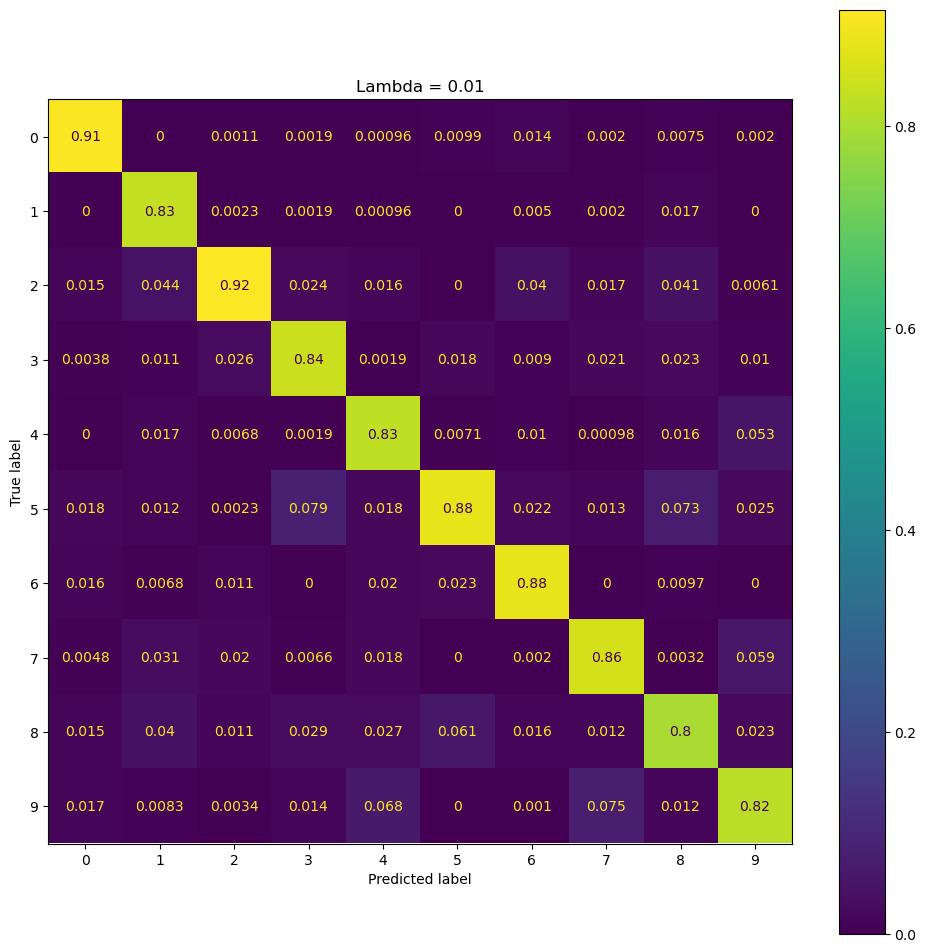

In [9]:
# Confusion matrix for lambda = 0.01
model_ind = 2
lambda_val = lambda_array[model_ind]       # select lambda = 0.01
model = clf_array[model_ind]
model_coef = model.coef_
plot_confusion(model_coef, test_A, test_label, lambda_val)


axs: [<Axes: >]


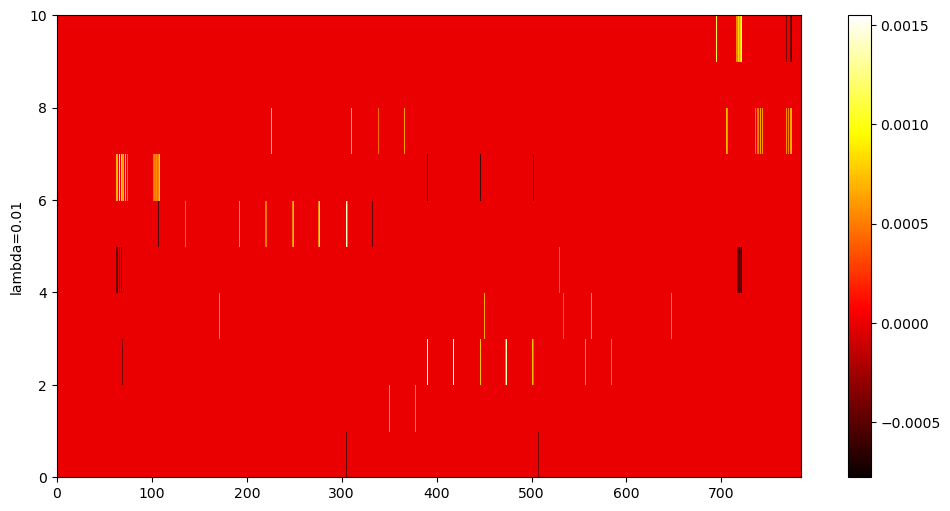

In [20]:
# Compress model for lambda = 0.01
def compress_model(coef,threshold):
    # compress model by zeroing all coefficients below threshold, where threshold is defined as the percentage of the max coef
    threshold_val = coef.max()*threshold
    comp_coef = copy.deepcopy(coef)
    comp_coef[np.abs(comp_coef) < threshold_val] = 0
    return comp_coef

model_0p25 = compress_model(model_coef, 0.25)
# plot_heat_map([model_0p25, model_0p25], [lambda_val, lambda_val])
plot_heat_map(model_0p25, lambda_val, fig_size_y=6)




